In [1]:
import os
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('..')

import numpy as np
import random
import torch
# %env CUDA_VISIBLE_DEVICES=1

from lib import data_processors, utils

In [2]:
params = {
    'data_dir': '../../data/SST-2',
    'output_dir': '../output',
    'cache_dir': '../model_cache',
    'task_name': 'sst2',
    'bert_model': 'bert-base-uncased',
    'max_seq_length': 128,
    'train_batch_size': 32,
    'eval_batch_size': 8,
    'learning_rate': 2e-5,
    'warmup_proportion': 0.1,
    'num_train_epochs': 1,
    'seed': 1331
}

processors = {
    'cola': data_processors.ColaProcessor,
    'mnli': data_processors.MnliProcessor,
    'mrpc': data_processors.MrpcProcessor,
    'sst2': data_processors.SST2Processor
}

num_labels_task = {
    'cola': 2,
    'mnli': 3,
    'mrpc': 2,
    'sst2': 2
}

random.seed(params['seed'])
np.random.seed(params['seed'])
torch.manual_seed(params['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from lib.bert import BertForSequenceClassification
from pytorch_pretrained_bert.tokenization import BertTokenizer

from lib.train_eval import train, evaluate

from lib.train_student import train_student 

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
processor = processors[params['task_name']]()
num_labels = num_labels_task[params['task_name']]
label_list = processor.get_labels()

tokenizer = BertTokenizer.from_pretrained(
    params['bert_model'], do_lower_case=True)

train_examples = processor.get_train_examples(params['data_dir'])
eval_examples = processor.get_dev_examples(params['data_dir'])

# teacher_model = BertForSequenceClassification.from_pretrained(
#     params['bert_model'], cache_dir=params['cache_dir'], num_labels=num_labels).to(device)

04/10/2019 18:19:56 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/shakhrayv/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


Скачаем дообученную модель

In [5]:
from pytorch_pretrained_bert.modeling import (BertConfig, WEIGHTS_NAME, CONFIG_NAME)

# Load a trained model and config that you have fine-tuned
config = BertConfig(os.path.join(params['output_dir'], CONFIG_NAME))
teacher_model = BertForSequenceClassification(config, num_labels=num_labels)
teacher_model.load_state_dict(torch.load(os.path.join(params['output_dir'], WEIGHTS_NAME)))
teacher_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertInterme

In [6]:
# teacher_model, result = train(teacher_model, train_examples, label_list, params, tokenizer)

Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    6312
Epoch: 1


Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch: 2


Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch: 3


Iteration: 100%|██████████| 2105/2105 [12:03<00:00,  3.18it/s]


In [9]:
# result = evaluate(teacher_model, eval_examples, label_list, params, tokenizer)
# result

03/14/2019 16:45:21 - INFO - lib.train_eval -   ***** Running evaluation *****
03/14/2019 16:45:21 - INFO - lib.train_eval -     Num examples = 872
03/14/2019 16:45:21 - INFO - lib.train_eval -     Batch size = 8
Evaluating: 100%|██████████| 109/109 [00:06<00:00, 17.47it/s]
03/14/2019 16:45:27 - INFO - lib.train_eval -   ***** Eval results *****
03/14/2019 16:45:27 - INFO - lib.train_eval -     eval_accuracy = 0.9277522935779816
03/14/2019 16:45:27 - INFO - lib.train_eval -     eval_loss = 0.24567339350597575


{'eval_loss': 0.24567339350597575, 'eval_accuracy': 0.9277522935779816}

## Дистилляция

Возьмем новую модель.

In [8]:
model = BertForSequenceClassification.from_pretrained(
    params['bert_model'], cache_dir=params['cache_dir'], num_labels=num_labels).to(device)

Уберем некоторые блоки из берта и получим студента, которого будет дообучать. А именно, в енкодере возьмем только первые 2 и последние 4 блока, а 6 посередине выкинем.

In [13]:
all_layers = model.bert.encoder.layer
model.bert.encoder.layer = all_layers[:2]

for i, t in enumerate(all_layers[8:]):
    model.bert.encoder.layer.add_module(str(i + 2), t) 

Во сколько раз уменьшаем? Посчитаем это по числу параметров.

In [15]:
all_count = 0
for p in model.named_parameters():
    cur_count = 1
    for sh in p[1].size():
        cur_count *= sh
        
    all_count += cur_count
    
print('compresing in {} times'.format(109483778 / all_count))

compresing in 1.635146741290986 times


Насколько хороша модель студент без обучения? Можно заметить, что в разы хуже, чем учитель.

In [20]:
result = evaluate(model, eval_examples, label_list, params, tokenizer)
result

03/14/2019 17:11:21 - INFO - lib.train_eval -   ***** Running evaluation *****
03/14/2019 17:11:21 - INFO - lib.train_eval -     Num examples = 872
03/14/2019 17:11:21 - INFO - lib.train_eval -     Batch size = 8
Evaluating: 100%|██████████| 109/109 [00:01<00:00, 96.92it/s]
03/14/2019 17:11:22 - INFO - lib.train_eval -   ***** Eval results *****
03/14/2019 17:11:22 - INFO - lib.train_eval -     eval_accuracy = 0.5091743119266054
03/14/2019 17:11:22 - INFO - lib.train_eval -     eval_loss = 1.0949557892499713


{'eval_loss': 1.0949557892499713, 'eval_accuracy': 0.5091743119266054}

Обучаем при помощи дистилляции.

In [21]:
model, result = train_student(model, teacher_model, train_examples, label_list, params, tokenizer)

Evaluating:   0%|          | 0/2105 [00:00<?, ?it/s]

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    6312


Iteration:   0%|          | 1/2105 [00:00<04:27,  7.87it/s]

Epoch: 1


Iteration:   0%|          | 2/2105 [00:00<02:23, 14.69it/s]

Epoch: 2


Iteration:   0%|          | 2/2105 [00:00<02:27, 14.27it/s]

Epoch: 3


Iteration: 100%|██████████| 2105/2105 [02:24<00:00, 14.61it/s]


Смотрим, что получилось.

In [16]:
result = evaluate(model, eval_examples, label_list, params, tokenizer)
result

03/14/2019 17:09:42 - INFO - lib.train_eval -   ***** Running evaluation *****
03/14/2019 17:09:42 - INFO - lib.train_eval -     Num examples = 872
03/14/2019 17:09:42 - INFO - lib.train_eval -     Batch size = 8
Evaluating: 100%|██████████| 109/109 [00:03<00:00, 33.87it/s]
03/14/2019 17:09:45 - INFO - lib.train_eval -   ***** Eval results *****
03/14/2019 17:09:45 - INFO - lib.train_eval -     eval_accuracy = 0.8922018348623854
03/14/2019 17:09:45 - INFO - lib.train_eval -     eval_loss = 0.46438410867928365


{'eval_loss': 0.46438410867928365, 'eval_accuracy': 0.8922018348623854}

## Эксперимент с важностью слоев

Возьмем все модели, полученные из исходного Берта выкидыванием 2ух блоков. Каждую такую модель обучим при помощи дистилляции, где учителем будет являться исходный Берт.

In [6]:
import itertools
from tqdm import tqdm, tqdm_notebook

module_indeces = list(itertools.combinations(np.arange(12), 10))

In [9]:
params['train_batch_size'] = 32
params['num_train_epochs'] = 3

Функция train_student для обучения модели при помощи дистиляции может принимать логиты учителя, а может не принимать. Если их ей не передали, то она их сама сгенерирует. Но нам не хочется, чтобы она каждый раз для новой модели их генерировала. Поэтому посчитаем их заранее. Это делает функция eval_teacher_soft_targets.

In [10]:
# compute soft logits from teacher
from lib.train_student import eval_teacher_soft_targets
from torch.utils.data import TensorDataset


train_features = utils.convert_examples_to_features(train_examples, label_list, 
                                                    params['max_seq_length'], tokenizer)

all_input_ids = torch.tensor([f.input_ids for f in train_features],
                         dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features],
                          dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features],
                           dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features],
                         dtype=torch.long)

eval_teacher_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

all_logits_teacher = eval_teacher_soft_targets(teacher_model, eval_teacher_dataset, label_list, params)

Evaluating: 100%|██████████| 2105/2105 [03:35<00:00,  9.62it/s]


Ну и обучаем все наши модельки.

In [11]:
# import pickle

# all_results = []

for indeces in tqdm(module_indeces[64:]):
    cur_result = []
    model = BertForSequenceClassification.from_pretrained(
    params['bert_model'], cache_dir=params['cache_dir'], num_labels=num_labels).to(device)
    
    all_layers = model.bert.encoder.layer

    new_layers = torch.nn.ModuleList()
    for j in indeces:
        new_layers.add_module(str(j), all_layers[j])
        
    model.bert.encoder.layer = new_layers
    
    cur_result.append(indeces)
    result = train_student(model, teacher_model, train_examples, label_list, params, 
                           tokenizer, all_logits_teacher=all_logits_teacher)
    
    cur_result.append(result)
    result = evaluate(model, eval_examples, label_list, params, tokenizer)
    cur_result.append(result)
    all_results.append(cur_result)
    with open('all_results.pickle', 'wb') as file:
        pickle.dump(all_results, file)
    
    print('{} layers, \n {}, {}'.format(cur_result[0], cur_result[1], cur_result[2]))
    

  0%|          | 0/2 [00:00<?, ?it/s]04/10/2019 18:24:01 - INFO - lib.bert -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/10/2019 18:24:01 - INFO - lib.bert -   extracting archive file ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpju_oikx5
04/10/2019 18:24:03 - INFO - lib.bert -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

04/10/2019 18:24:05 - INFO - lib.bert -   Weights of Be

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    6312
Epoch: 1


../lib/train_student.py:113: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."

It

Iteration:  23%|██▎       | 490/2105 [02:33<08:19,  3.23it/s]


Iteration:  35%|███▌      | 742/2105 [03:51<07:01,  3.23it/s]


Iteration:  47%|████▋     | 994/2105 [05:10<05:44,  3.22it/s]


Iteration:  59%|█████▉    | 1242/2105 [06:27<04:29,  3.21it/s]


Iteration:  71%|███████   | 1490/2105 [07:44<03:11,  3.22it/s]


Iteration:  83%|████████▎ | 1738/2105 [09:02<01:54,  3.22it/s]


Iteration:  94%|█████████▍| 1986/2105 [10:19<00:37,  3.20it/s]


Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch: 2



Iteration:  12%|█▏        | 253/2105 [01:19<09:36,  3.21it/s]


Iteration:  24%|██▍       | 505/2105 [02:37<08:20,  3.20it/s]


Iteration:  36%|███▌      | 757/2105 [03:56<07:00,  3.21it/s]


Iteration:  48%|████▊     | 1008/2105 [05:14<05:40,  3.22it/s]


Iteration:  60%|█████▉    | 1256/2105 [06:31<04:22,  3.23it/s]


Iteration:  71%|███████▏  | 1504/2105 [07:48<03:06,  3.22it/s]


Iteration:  83%|████████▎ | 1752/2105 [09:05<01:49,  3.21it/s]


Iteration:  95%|█████████▌| 2000/2105 [10:19<00:30,  3.47it/s]


Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch: 3



Iteration:  12%|█▏        | 253/2105 [01:14<09:46,  3.16it/s]


Iteration:  24%|██▍       | 505/2105 [02:29<07:51,  3.39it/s]


Iteration:  36%|███▌      | 757/2105 [03:44<06:36,  3.40it/s]


Iteration:  48%|████▊     | 1008/2105 [04:57<05:22,  3.40it/s]


Iteration:  60%|█████▉    | 1256/2105 [06:11<04:10,  3.38it/s]


Iteration:  71%|███████▏  | 1504/2105 [07:24<02:56,  3.41it/s]


Iteration:  83%|████████▎ | 1752/2105 [08:37<01:45,  3.35it/s]


Iteration:  95%|█████████▌| 2000/2105 [09:51<00:31,  3.37it/s]


Iteration: 100%|██████████| 2105/2105 [10:21<00:00,  3.69it/s]04/10/2019 18:56:20 - INFO - lib.train_eval -   ***** Running evaluation *****
04/10/2019 18:56:20 - INFO - lib.train_eval -     Num examples = 872
04/10/2019 18:56:20 - INFO - lib.train_eval -     Batch size = 8

Evaluating: 100%|██████████| 109/109 [00:05<00:00, 20.48it/s]04/10/2019 18:56:26 - INFO - lib.train_eval -   ***** Eval results *****
04/10/2019 18:56:26 - INFO - lib.train_eval -     eval_accuracy = 0.9243119266055045
04/10/2019 18:56:26 - INFO - lib.train_eval -     eval_loss = 0.30474341312132847
 50%|█████     | 1/2 [32:25<32:25, 1945.50s/it]

(1, 3, 4, 5, 6, 7, 8, 9, 10, 11) layers, 
 {'loss': 0.11660049618918653, 'global_step': 6315}, {'eval_loss': 0.30474341312132847, 'eval_accuracy': 0.9243119266055045}


04/10/2019 18:56:27 - INFO - lib.bert -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/10/2019 18:56:27 - INFO - lib.bert -   extracting archive file ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpe5voubcw
04/10/2019 18:56:29 - INFO - lib.bert -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

04/10/2019 18:56:31 - INFO - lib.bert -   Weights of BertForSequenceClassification not initi

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    6312
Epoch: 1



Iteration:  12%|█▏        | 253/2105 [01:14<09:06,  3.39it/s]


Iteration:  24%|██▍       | 505/2105 [02:29<07:53,  3.38it/s]


Iteration:  36%|███▌      | 757/2105 [03:43<06:37,  3.39it/s]


Iteration:  48%|████▊     | 1008/2105 [04:57<05:25,  3.37it/s]


Iteration:  60%|█████▉    | 1256/2105 [06:11<04:10,  3.39it/s]


Iteration:  71%|███████▏  | 1504/2105 [07:24<02:57,  3.39it/s]


Iteration:  83%|████████▎ | 1752/2105 [08:38<01:44,  3.37it/s]


Iteration:  95%|█████████▌| 2000/2105 [09:51<00:30,  3.40it/s]


Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch: 2



Iteration:  12%|█▏        | 253/2105 [01:14<09:09,  3.37it/s]


Iteration:  24%|██▍       | 505/2105 [02:29<07:50,  3.40it/s]


Iteration:  36%|███▌      | 757/2105 [03:43<06:55,  3.25it/s]


Iteration:  48%|████▊     | 1008/2105 [04:57<05:25,  3.37it/s]


Iteration:  60%|█████▉    | 1256/2105 [06:13<04:09,  3.40it/s]


Iteration:  71%|███████▏  | 1504/2105 [07:26<02:57,  3.38it/s]


Iteration:  83%|████████▎ | 1752/2105 [08:39<01:44,  3.37it/s]


Iteration:  95%|█████████▌| 2000/2105 [09:53<00:31,  3.36it/s]


Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch: 3



Iteration:  12%|█▏        | 253/2105 [01:14<09:04,  3.40it/s]


Iteration:  24%|██▍       | 505/2105 [02:29<07:55,  3.37it/s]


Iteration:  36%|███▌      | 757/2105 [03:43<06:37,  3.39it/s]


Iteration:  48%|████▊     | 1008/2105 [04:57<05:25,  3.37it/s]


Iteration:  60%|█████▉    | 1256/2105 [06:11<04:18,  3.28it/s]


Iteration:  71%|███████▏  | 1504/2105 [07:25<02:57,  3.39it/s]


Iteration:  83%|████████▎ | 1752/2105 [08:38<01:44,  3.38it/s]


Iteration:  95%|█████████▌| 2000/2105 [09:52<00:31,  3.38it/s]


Iteration: 100%|██████████| 2105/2105 [10:23<00:00,  3.69it/s]04/10/2019 19:27:48 - INFO - lib.train_eval -   ***** Running evaluation *****
04/10/2019 19:27:48 - INFO - lib.train_eval -     Num examples = 872
04/10/2019 19:27:48 - INFO - lib.train_eval -     Batch size = 8

Evaluating: 100%|██████████| 109/109 [00:05<00:00, 20.41it/s]04/10/2019 19:27:53 - INFO - lib.train_eval -   ***** Eval results *****
04/10/2019 19:27:53 - INFO - lib.train_eval -     eval_accuracy = 0.9231651376146789
04/10/2019 19:27:53 - INFO - lib.train_eval -     eval_loss = 0.31084395500771494
100%|██████████| 2/2 [1:03:52<00:00, 1928.08s/it]

(2, 3, 4, 5, 6, 7, 8, 9, 10, 11) layers, 
 {'loss': 0.1177525123749415, 'global_step': 6315}, {'eval_loss': 0.31084395500771494, 'eval_accuracy': 0.9231651376146789}


In [16]:
import pickle

with open('all_results.pickle', 'rb') as f:
    all_results = pickle.load(f)

In [17]:
all_results

[[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
  {'loss': 0.09038740899192607, 'global_step': 6315},
  {'eval_loss': 0.3197768413965855, 'eval_accuracy': 0.9277522935779816}],
 [(0, 1, 2, 3, 4, 5, 6, 7, 8, 10),
  {'loss': 0.09045047856991195, 'global_step': 6315},
  {'eval_loss': 0.33365590952405144, 'eval_accuracy': 0.9197247706422018}],
 [(0, 1, 2, 3, 4, 5, 6, 7, 8, 11),
  {'loss': 0.09097302282127306, 'global_step': 6315},
  {'eval_loss': 0.29997434029611975, 'eval_accuracy': 0.9288990825688074}],
 [(0, 1, 2, 3, 4, 5, 6, 7, 9, 10),
  {'loss': 0.09419256271506857, 'global_step': 6315},
  {'eval_loss': 0.317273432645229, 'eval_accuracy': 0.9220183486238532}],
 [(0, 1, 2, 3, 4, 5, 6, 7, 9, 11),
  {'loss': 0.09409053696500859, 'global_step': 6315},
  {'eval_loss': 0.3266130508427773, 'eval_accuracy': 0.9174311926605505}],
 [(0, 1, 2, 3, 4, 5, 6, 7, 10, 11),
  {'loss': 0.09725489376019908, 'global_step': 6315},
  {'eval_loss': 0.330082887869089, 'eval_accuracy': 0.9231651376146789}],
 [(0, 1, 2, 3, 4

In [12]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [12]:
len(all_results)

66

Среднее качество без определенного слоя (для каждого слоя)

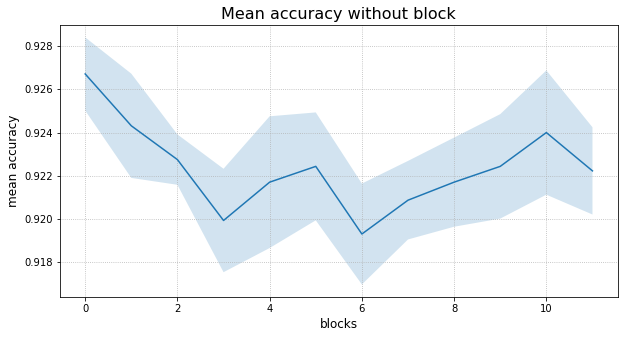

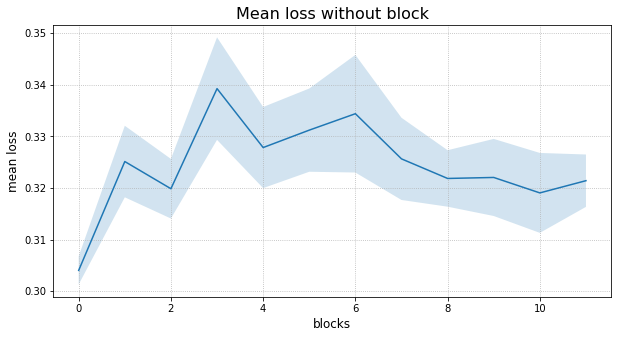

In [13]:
import numpy as np
import matplotlib.pyplot as plt


accs_without = [[] for _ in range(12)]
losses_without = [[] for _ in range(12)]

for res in all_results:
    for i in range(12):
        if i not in res[0]:
            accs_without[i].append(res[2]['eval_accuracy'])
            losses_without[i].append(res[2]['eval_loss'])

            
mean_acc_without = np.array([mean_confidence_interval(acc) for acc in accs_without])
mean_locc_without = np.array([mean_confidence_interval(loss) for loss in losses_without])


plt.figure(figsize=(10, 5))
plt.plot(np.arange(12),  mean_acc_without[:, 0])
plt.fill_between(np.arange(12), mean_acc_without[:, 1], mean_acc_without[:, 2], alpha=.2)
plt.grid(ls=':')
plt.title('Mean accuracy without block', fontsize=16)
plt.xlabel('blocks', fontsize=12)
plt.ylabel('mean accuracy', fontsize=12)
plt.show();


plt.figure(figsize=(10, 5))
plt.plot(np.arange(12),  mean_locc_without[:, 0])
plt.fill_between(np.arange(12), mean_locc_without[:, 1], mean_locc_without[:, 2], alpha=.2)
plt.grid(ls=':')
plt.title('Mean loss without block', fontsize=16)
plt.xlabel('blocks', fontsize=12)
plt.ylabel('mean loss', fontsize=12)
plt.show();

Среднее качество с определенным слоем (для каждого слоя)

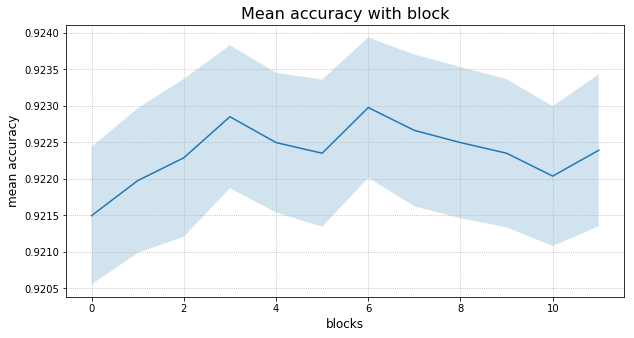

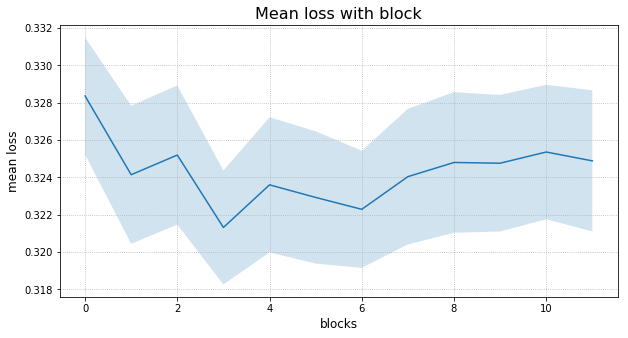

In [14]:
accs_with = [[] for _ in range(12)]
losses_with = [[] for _ in range(12)]

for res in all_results:
    for i in range(12):
        if i in res[0]:
            accs_with[i].append(res[2]['eval_accuracy'])
            losses_with[i].append(res[2]['eval_loss'])

            
mean_acc_with = np.array([mean_confidence_interval(acc) for acc in accs_with])
mean_locc_with = np.array([mean_confidence_interval(loss) for loss in losses_with])



plt.figure(figsize=(10, 5))
plt.plot(np.arange(12),  mean_acc_with[:, 0])
plt.fill_between(np.arange(12), mean_acc_with[:, 1], mean_acc_with[:, 2], alpha=.2)
plt.grid(ls=':')
plt.title('Mean accuracy with block', fontsize=16)
plt.xlabel('blocks', fontsize=12)
plt.ylabel('mean accuracy', fontsize=12)
plt.show();


plt.figure(figsize=(10, 5))
plt.plot(np.arange(12),  mean_locc_with[:, 0])
plt.fill_between(np.arange(12), mean_locc_with[:, 1], mean_locc_with[:, 2], alpha=.2)
plt.grid(ls=':')
plt.title('Mean loss with block', fontsize=16)
plt.xlabel('blocks', fontsize=12)
plt.ylabel('mean loss', fontsize=12)
plt.show();